In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

In [3]:

# VERİ YÜKLEME VE HAZIRLIK

# dosya yolları
X_train_file = '/content/drive/MyDrive/trainvetest/X_train.csv'
X_test_file = '/content/drive/MyDrive/trainvetest/X_test.csv'
y_train_file = '/content/drive/MyDrive/trainvetest/y_train.csv'
y_test_file = '/content/drive/MyDrive/trainvetest/y_test.csv'

# veri setlerini yükleme
X_train_full = pd.read_csv(X_train_file)
X_test_full = pd.read_csv(X_test_file)
y_train = pd.read_csv(y_train_file)['target'].values.ravel()
y_test = pd.read_csv(y_test_file)['target'].values.ravel()

print(f"Başlangıç Özellik Sayısı: {X_train_full.shape[1]}")

Başlangıç Özellik Sayısı: 132


In [4]:

#  ÖZELLİK SEÇİMİ

# SelectKBest ile en iyi 50 özelliği seçme
K_FEATURES = 50
selector = SelectKBest(score_func=f_classif, k=K_FEATURES)

# eğitim verileri üzerinde fit etme ve dönüştürme
X_train_selected = selector.fit_transform(X_train_full, y_train)

# seçtiğimiz özellikleri test verilerine uygulama
X_test_selected = selector.transform(X_test_full)

# seçtiğimiz özellik isimlerini bulma
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train_full.columns[selected_feature_indices].tolist()

print(f"Seçilen Özellik Sayısı (K): {K_FEATURES}")
print(f"Özellik Seçimi Tamamlandı. Yeni X_train boyutu: {X_train_selected.shape}")

Seçilen Özellik Sayısı (K): 50
Özellik Seçimi Tamamlandı. Yeni X_train boyutu: (81410, 50)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 64  97 117] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [5]:
# YARDIMCI GÖRSELLEŞTİRME FONKSİYONU

def plot_confusion_matrix(cm, model_name, filename):
    """Karmaşıklık Matrisini görselleştirir ve kaydeder."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Tahmin Negatif (0)', 'Tahmin Pozitif (1)'],
                yticklabels=['Gerçek Negatif (0)', 'Gerçek Pozitif (1)'])
    plt.title(f'{model_name} Karmaşıklık Matrisi')
    plt.ylabel('Gerçek Sınıf')
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [6]:
#  EĞİTİM, DEĞERLENDİRME VE GÖRSELLEŞTİRME FONKSİYONU

def train_evaluate_and_plot(model, X_train, y_train, X_test, y_test, model_name):
    """Modeli eğitir, değerlendirir ve sonuçları yazdırıp görselleştirir."""

    # modeli Eğitme
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"\n[UYARI] {model_name} eğitim hatası: {e}.")
        return

    # tahmin yapma
    y_pred = model.predict(X_test)

    # metrikleri hesaplama
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Konsol Çıktısı
    print(f"\n========================================================")
    print(f"               {model_name} SONUÇLARI                   ")
    print(f"========================================================")
    print(f"Doğruluk (Accuracy): {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # karmaşıklık Matrisi Tablo Çıktısı
    cm_df = pd.DataFrame(cm,
                         index=['Gerçek Negatif (0)', 'Gerçek Pozitif (1)'],
                         columns=['Tahmin Negatif (0)', 'Tahmin Pozitif (1)'])
    print("\n--- Karmaşıklık Matrisi Tablosu ---")
    print(cm_df)

    # karmaşıklık Matrisi Görselleştirme
    plot_confusion_matrix(cm, model_name, f"{model_name}_cm_heatmap.png")

    # ROC Eğrisi ve AUC Hesaplama ve Görselleştirme
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Eğrisi')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(f"{model_name}_roc_curve.png")
        plt.show()
        print(f"ROC AUC Skoru: {roc_auc:.4f}")
    else:
        print(f"[BİLGİ] {model_name} modeli predict_proba metoduna sahip değil, ROC eğrisi çizilemedi.")

***MODELLERİN BASE PARAMETRELER İLE ÇALIŞTIRILMASI***

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")



               MLP_Original (Adam) SONUÇLARI                   
Doğruluk (Accuracy): 0.8887
F1-Score: 0.0233

--- Karmaşıklık Matrisi Tablosu ---
                    Tahmin Negatif (0)  Tahmin Pozitif (1)
Gerçek Negatif (0)               18061                  21
Gerçek Pozitif (1)                2244                  27


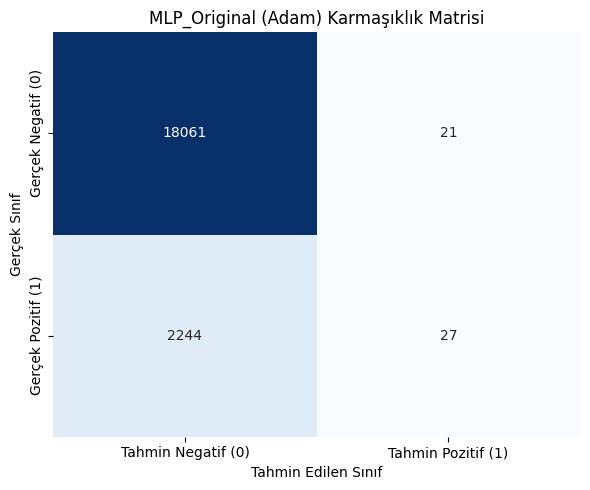

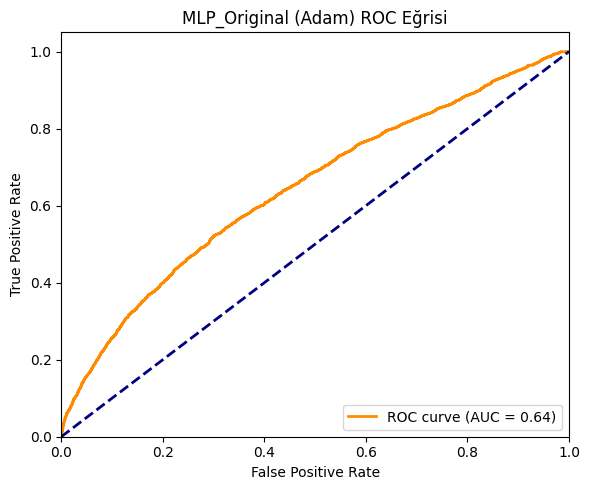

ROC AUC Skoru: 0.6435

               MLP_New_Params (SGD) SONUÇLARI                   
Doğruluk (Accuracy): 0.8887
F1-Score: 0.0096

--- Karmaşıklık Matrisi Tablosu ---
                    Tahmin Negatif (0)  Tahmin Pozitif (1)
Gerçek Negatif (0)               18077                   5
Gerçek Pozitif (1)                2260                  11


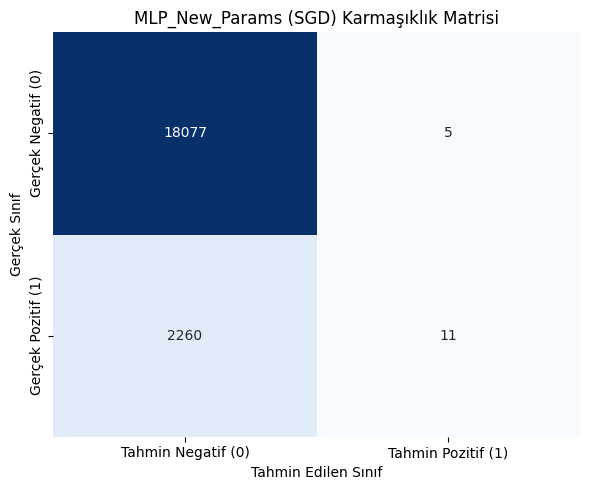

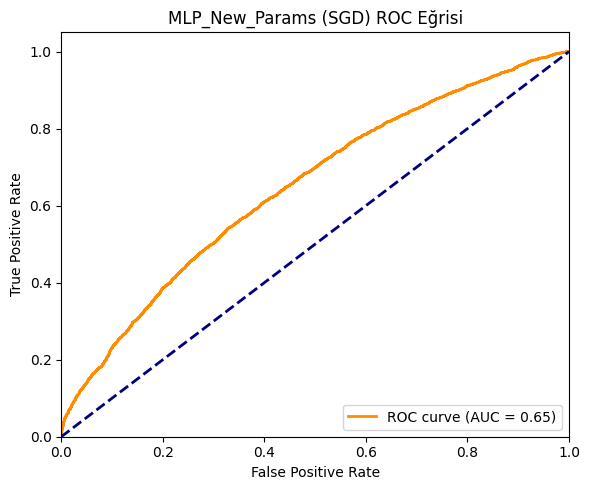

ROC AUC Skoru: 0.6465


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



               MLP_New_Params_2 (LBFGS) SONUÇLARI                   
Doğruluk (Accuracy): 0.8885
F1-Score: 0.0258

--- Karmaşıklık Matrisi Tablosu ---
                    Tahmin Negatif (0)  Tahmin Pozitif (1)
Gerçek Negatif (0)               18054                  28
Gerçek Pozitif (1)                2241                  30


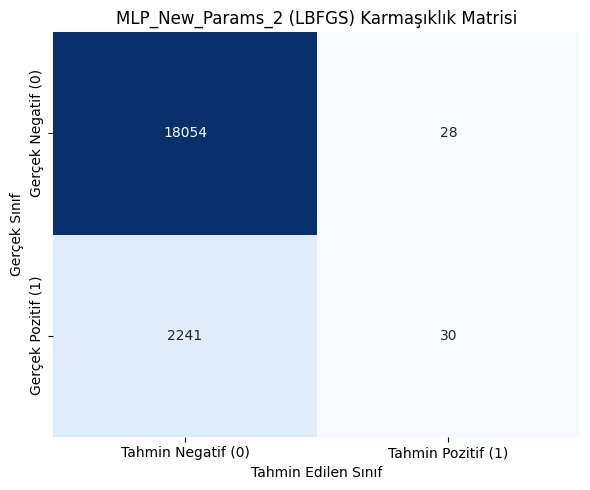

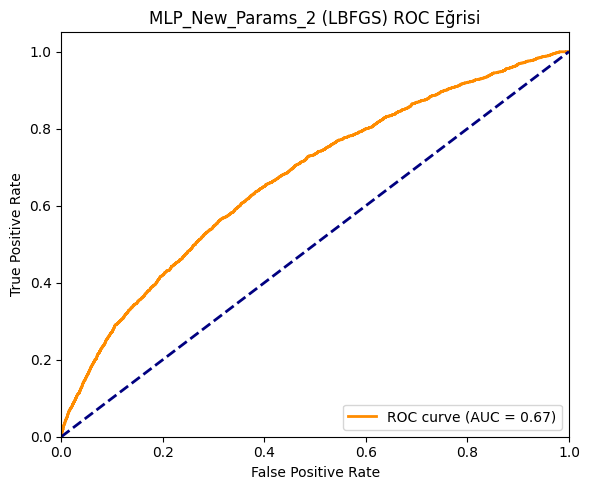

ROC AUC Skoru: 0.6700


In [8]:
# --- MLP Modelleri ---
mlp_orig = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=300, activation='relu', solver='adam', random_state=42)
train_evaluate_and_plot(mlp_orig, X_train_selected, y_train, X_test_selected, y_test, "MLP_Original (Adam)")

mlp_new_params = MLPClassifier(hidden_layer_sizes=(150,), max_iter=500, activation='tanh', solver='sgd', random_state=42)
train_evaluate_and_plot(mlp_new_params, X_train_selected, y_train, X_test_selected, y_test, "MLP_New_Params (SGD)")

mlp_new_params_2 = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=500, activation='relu', solver='lbfgs', random_state=42)
train_evaluate_and_plot(mlp_new_params_2, X_train_selected, y_train, X_test_selected, y_test, "MLP_New_Params_2 (LBFGS)")


               Perceptron_Original (No Penalty) SONUÇLARI                   
Doğruluk (Accuracy): 0.8880
F1-Score: 0.0532

--- Karmaşıklık Matrisi Tablosu ---
                    Tahmin Negatif (0)  Tahmin Pozitif (1)
Gerçek Negatif (0)               18009                  73
Gerçek Pozitif (1)                2207                  64


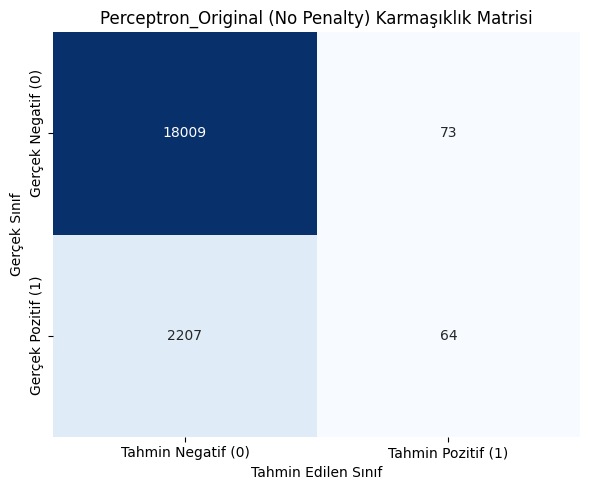

[BİLGİ] Perceptron_Original (No Penalty) modeli predict_proba metoduna sahip değil, ROC eğrisi çizilemedi.

               Perceptron_New_Params (L2 Penalty) SONUÇLARI                   
Doğruluk (Accuracy): 0.8871
F1-Score: 0.0457

--- Karmaşıklık Matrisi Tablosu ---
                    Tahmin Negatif (0)  Tahmin Pozitif (1)
Gerçek Negatif (0)               18001                  81
Gerçek Pozitif (1)                2216                  55


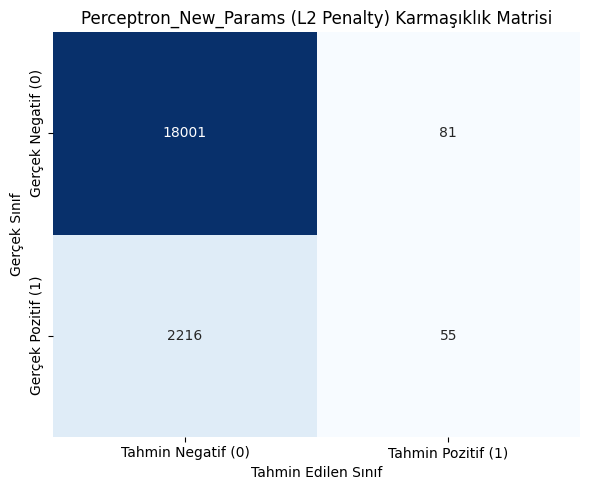

[BİLGİ] Perceptron_New_Params (L2 Penalty) modeli predict_proba metoduna sahip değil, ROC eğrisi çizilemedi.

               Perceptron_New_Params_2 (L1 Penalty) SONUÇLARI                   
Doğruluk (Accuracy): 0.8597
F1-Score: 0.0775

--- Karmaşıklık Matrisi Tablosu ---
                    Tahmin Negatif (0)  Tahmin Pozitif (1)
Gerçek Negatif (0)               17378                 704
Gerçek Pozitif (1)                2151                 120


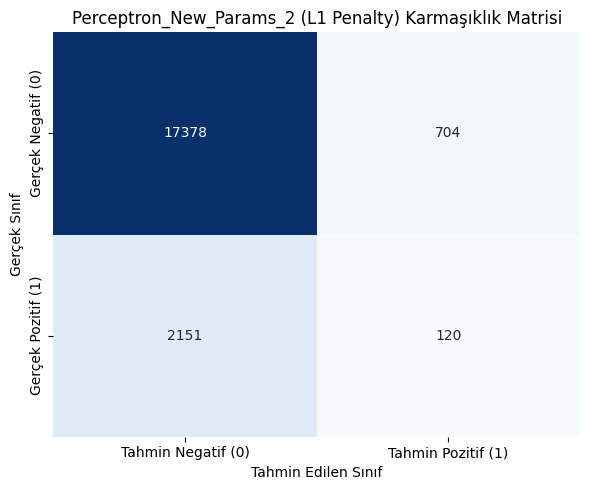

[BİLGİ] Perceptron_New_Params_2 (L1 Penalty) modeli predict_proba metoduna sahip değil, ROC eğrisi çizilemedi.


In [9]:
# --- Perceptron Modelleri ---
perc_orig = Perceptron(max_iter=500, tol=1e-3, shuffle=True, random_state=42)
train_evaluate_and_plot(perc_orig, X_train_selected, y_train, X_test_selected, y_test, "Perceptron_Original (No Penalty)")

perc_new_params = Perceptron(penalty='l2', alpha=0.0001, max_iter=500, tol=1e-4, shuffle=True, random_state=42)
train_evaluate_and_plot(perc_new_params, X_train_selected, y_train, X_test_selected, y_test, "Perceptron_New_Params (L2 Penalty)")

perc_new_params_2 = Perceptron(penalty='l1', alpha=0.0001, max_iter=1000, tol=1e-3, shuffle=True, random_state=42)
train_evaluate_and_plot(perc_new_params_2, X_train_selected, y_train, X_test_selected, y_test, "Perceptron_New_Params_2 (L1 Penalty)")

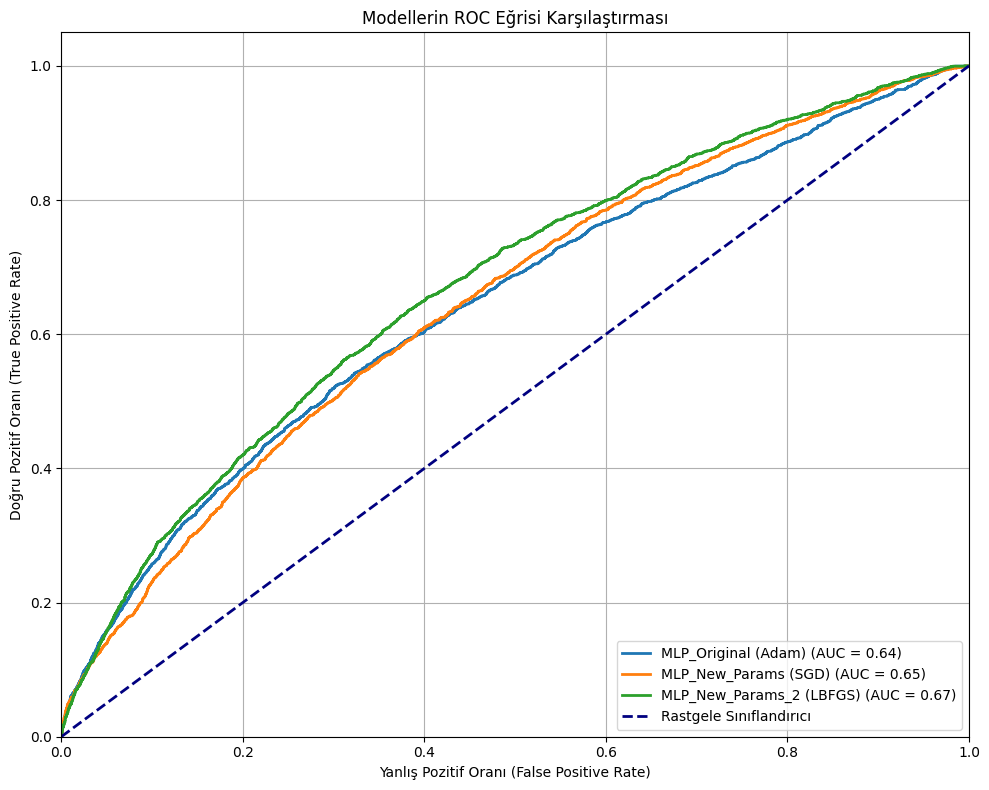

Ortak ROC eğrisi grafiği 'Combined_ROC_Curves.png' olarak kaydedildi.


In [11]:
roc_data = []

models_to_compare = {
    "MLP_Original (Adam)": mlp_orig,
    "MLP_New_Params (SGD)": mlp_new_params,
    "MLP_New_Params_2 (LBFGS)": mlp_new_params_2
}

for name, model in models_to_compare.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        roc_data.append({"name": name, "fpr": fpr, "tpr": tpr, "auc": roc_auc})
    else:
        print(f"[BİLGİ] {name} modeli predict_proba metoduna sahip değil, ROC eğrisi hesaplanamadı.")

plt.figure(figsize=(10, 8))
for data in roc_data:
    plt.plot(data['fpr'], data['tpr'], lw=2, label=f'{data["name"]} (AUC = {data["auc"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Sınıflandırıcı')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
plt.title('Modellerin ROC Eğrisi Karşılaştırması')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("Combined_ROC_Curves.png")
plt.show()
print("Ortak ROC eğrisi grafiği 'Combined_ROC_Curves.png' olarak kaydedildi.")

### Modellerin Doğruluk ve F1-Score Metriklerinin Karşılaştırılması



In [12]:
results = []

def collect_metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({"Model": model_name, "Accuracy": accuracy, "F1-Score": f1})

# Collect metrics for MLP models
collect_metrics(mlp_orig, X_test_selected, y_test, "MLP_Original (Adam)")
collect_metrics(mlp_new_params, X_test_selected, y_test, "MLP_New_Params (SGD)")
collect_metrics(mlp_new_params_2, X_test_selected, y_test, "MLP_New_Params_2 (LBFGS)")

# Collect metrics for Perceptron models
collect_metrics(perc_orig, X_test_selected, y_test, "Perceptron_Original (No Penalty)")
collect_metrics(perc_new_params, X_test_selected, y_test, "Perceptron_New_Params (L2 Penalty)")
collect_metrics(perc_new_params_2, X_test_selected, y_test, "Perceptron_New_Params_2 (L1 Penalty)")

results_df = pd.DataFrame(results)

display(results_df.head(len(results_df)))


,Model,Accuracy,F1-Score
0,MLP_Original (Adam),0.888714,0.023286
1,MLP_New_Params (SGD),0.888714,0.009620
2,MLP_New_Params_2 (LBFGS),0.888518,0.025762
3,Perceptron_Original (No Penalty),0.887977,0.053156
4,Perceptron_New_Params (L2 Penalty),0.887142,0.045700
5,Perceptron_New_Params_2 (L1 Penalty),0.859726,0.077544


/tmp/ipython-input-2506293645.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


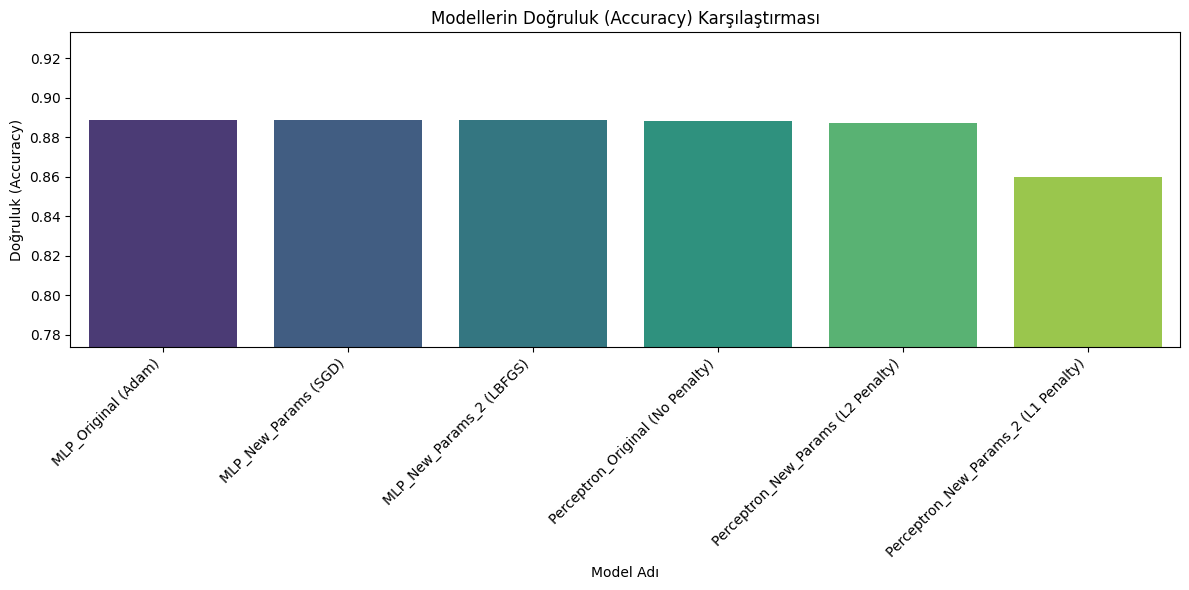

/tmp/ipython-input-2506293645.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-Score', data=results_df, palette='magma')


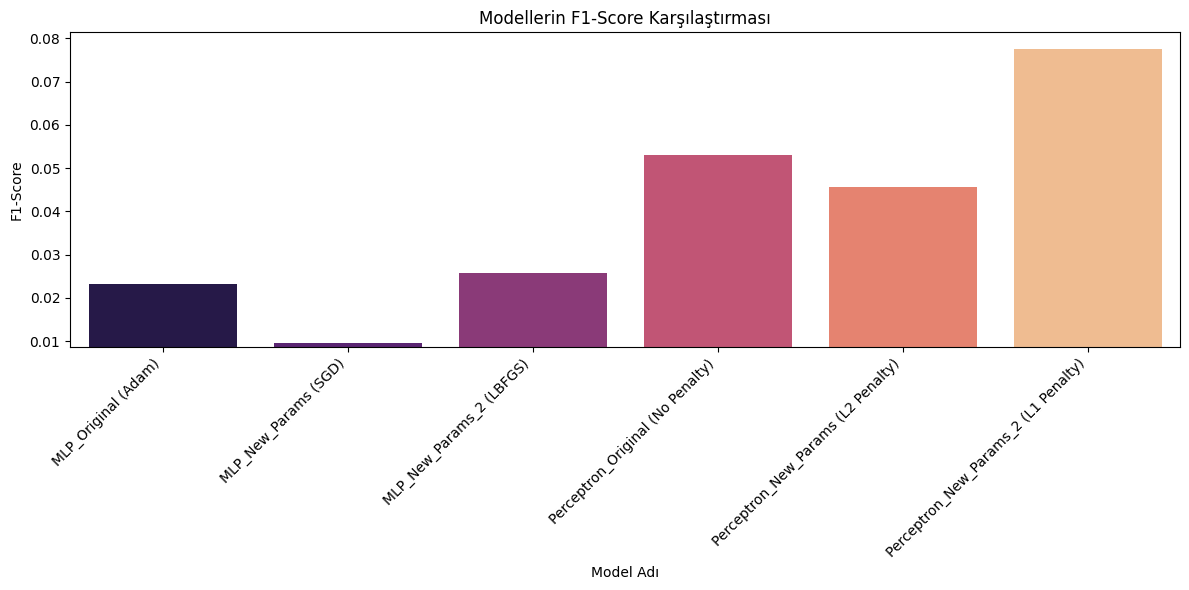

Model karşılaştırma grafikleri 'Model_Accuracy_Comparison.png' ve 'Model_F1_Score_Comparison.png' olarak kaydedildi.


In [13]:
# Accuracy karşılaştırma grafiği
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Modellerin Doğruluk (Accuracy) Karşılaştırması')
plt.xlabel('Model Adı')
plt.ylabel('Doğruluk (Accuracy)')
plt.xticks(rotation=45, ha='right')
plt.ylim(results_df['Accuracy'].min() * 0.9, results_df['Accuracy'].max() * 1.05) # Grafiği daha anlamlı kılmak için y ekseni limitlerini ayarla
plt.tight_layout()
plt.savefig('Model_Accuracy_Comparison.png')
plt.show()

# F1-Score karşılaştırma grafiği
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-Score', data=results_df, palette='magma')
plt.title('Modellerin F1-Score Karşılaştırması')
plt.xlabel('Model Adı')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(results_df['F1-Score'].min() * 0.9, results_df['F1-Score'].max() * 1.05) # Grafiği daha anlamlı kılmak için y ekseni limitlerini ayarla
plt.tight_layout()
plt.savefig('Model_F1_Score_Comparison.png')
plt.show()

print("Model karşılaştırma grafikleri 'Model_Accuracy_Comparison.png' ve 'Model_F1_Score_Comparison.png' olarak kaydedildi.")
